# Introduction to Data Science 2022

# Week 6: Recap

## Exercise 1 | Linear regression with feature selection

Download the [TED Talks](https://www.kaggle.com/rounakbanik/ted-talks) dataset from Kaggle. Your task is to predict both the ratings and the number of views of a given TED talk. You should focus only on the <span style="background-color: #c177f2">ted_main</span> table.

1. Download the data, extract the following ratings from column <span style="background-color: #c177f2">ratings</span>: <span style="background-color: #c177f2">Funny</span>, <span style="background-color: #c177f2">Confusing</span>, <span style="background-color: #c177f2">Inspiring</span>. Store these values into respective columns so that they are easier to access. Next, extract the tags from column <span style="background-color: #c177f2">tags</span>. Count the number of occurrences of each tag and select the top-100 most common tags. Create a binary variable for each of these and include them in your data table, so that you can directly see whether a given tag (among the top-100 tags) is used in a given TED talk or not. The dataset you compose should have dimension (2550, 104), and comprise of the 'views' column, the three columns with counts of "Funny", "Confusing and "Inspiring" ratings, and 100 columns which one-hot encode the top-100 most common tag columns.


In [1]:
import pandas as pd
import numpy as np
import ast 

df = pd.read_csv('ted_main.csv')
df.shape

(2550, 17)

In [2]:
def get_count(rating, name):
    rat = ast.literal_eval(rating)
    for i in rat:
        if i["name"]!= name: continue
        else: return i['count']

In [3]:
# get the ratings
# views, funny-rating, confusing-rating, inspiring-rating, 100 tags ...

df = df[['ratings','tags', 'views']]

df['funny-rating'] = df.apply(lambda row: get_count(row['ratings'], 'Funny'), axis=1)
df['confusing-rating'] = df.apply(lambda row: get_count(row['ratings'], 'Confusing'), axis=1)
df['inspiring-rating'] = df.apply(lambda row: get_count(row['ratings'], 'Inspiring'), axis=1)

In [4]:
# get the 100 most popular tags and add them as a column 
def get_counts(tags_df):
    count_dict = {}
    for row in tags_df:
        row = ast.literal_eval(row)
        for tag in row:
            if tag not in count_dict: 
                count_dict[tag] = 1
            else: count_dict[tag] +=1
    return count_dict

def get_100_most_popular():
    counts = get_counts(df['tags'])
    result = sorted(counts, key=lambda x: counts[x], reverse=True)
    return result[0:100]

most_popular = get_100_most_popular()
for tag in most_popular:
    df[tag] = df.apply(lambda row: 1 if tag in row['tags'] else 0, axis=1)
df = df.drop(columns=['ratings', 'tags'])
print(df.head())
df.shape

      views  funny-rating  confusing-rating  inspiring-rating  technology  \
0  47227110         19645               242             24924           0   
1   3200520           544                62               413           1   
2   1636292           964                27               230           1   
3   1697550            59                32              1070           0   
4  12005869          1390                72              2893           0   

   science  global issues  culture  TEDx  design  ...  food  religion  peace  \
0        0              0        1     0       0  ...     0         0      0   
1        1              1        1     0       0  ...     0         0      0   
2        0              0        0     0       1  ...     0         0      0   
3        0              0        0     0       0  ...     0         0      0   
4        0              1        0     0       0  ...     0         0      0   

   ecology  family  demo  poetry  illness  universe  ene

(2550, 104)

2. Construct a linear regression model to predict the number of views based on the data in the <span style="background-color: #c177f2">ted_main</span> table, including the binary variables for the top-100 tags that you just created.

In [5]:
# imports 
import numpy as np
from sklearn import datasets, linear_model, feature_selection
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [6]:
def train_for_input_row(input_row):
    # prepare the training and testing data 
    train = df[:2000].drop(['funny-rating','confusing-rating','inspiring-rating'], axis=1)
    test = df[2000:].drop(['funny-rating','confusing-rating','inspiring-rating'], axis=1)
    
    x_train = train
    y_train = df[:2000][input_row]

    x_test = test
    y_test = df[2000:][input_row]
    

    # train the model
    regr = linear_model.LinearRegression()
    model = regr.fit(x_train, y_train)

    # making predictions
    predictions = model.predict(x_test)

    # model evaluation
    print("Linear Regression model predicting value of: " + input_row)
    print('mean_squared_error : ', mean_squared_error(y_test, predictions))
    print('mean_absolute_error : ', mean_absolute_error(y_test, predictions))

In [7]:
train_for_input_row('views')

Linear Regression model predicting value of: views
mean_squared_error :  4.753826110773871e-19
mean_absolute_error :  5.164607004685836e-10


3. Do the same for the <span style="background-color: #c177f2">Funny</span>, <span style="background-color: #c177f2">Confusing</span>, and <span style="background-color: #c177f2">Inspiring</span> ratings.

In [8]:
print(train_for_input_row('funny-rating'))
print(train_for_input_row('confusing-rating'))
print(train_for_input_row('inspiring-rating'))

Linear Regression model predicting value of: funny-rating
mean_squared_error :  136243.0271271222
mean_absolute_error :  171.64345234899898
None
Linear Regression model predicting value of: confusing-rating
mean_squared_error :  351.11683735366336
mean_absolute_error :  13.765198730847858
None
Linear Regression model predicting value of: inspiring-rating
mean_squared_error :  515490.73258899344
mean_absolute_error :  479.29094326728364
None


4. You will probably notice that most of the tags are not useful in predicting the views and the ratings. You should use some kind of variable selection to prune the set of tags that are included in the model. You can use for example classical p-values or more modern [LASSO](https://en.wikipedia.org/wiki/Lasso_(statistics)) techniques. Which tags are the best predictors of each of the response variables?

In [9]:
def get_significant_p_vals_df(input_row):
    # prepare the training and testing data 
    train = df.drop(['funny-rating','confusing-rating','inspiring-rating'], axis=1)
    
    x = train
    y = df[input_row]

    # get p-vals
    p_values = np.array(feature_selection.f_regression(x, y)[1])
    
    # build df of cols only who have p-val <=.05
    significant_p_val_table = pd.DataFrame([])
    truthy_p_values = p_values<=.05
    
    for i,value in enumerate(truthy_p_values):
        if value:
            column_name = x.columns[i]
            significant_p_val_table[column_name] = x.loc[:,column_name]
            print(column_name, 'has p-value: ', p_values[i])
            
    print(significant_p_val_table.shape)
    return significant_p_val_table

In [10]:
p_val_df = get_significant_p_vals_df('views')

technology has p-value:  0.0013481754523512574
global issues has p-value:  1.3846644195001775e-05
culture has p-value:  6.512841082217395e-08
design has p-value:  0.000592189939694601
business has p-value:  0.0010192379168437221
art has p-value:  0.0003884222620904655
future has p-value:  0.02654829574579113
collaboration has p-value:  0.03339249666782307
environment has p-value:  0.0022170672625839547
brain has p-value:  2.946539582016628e-09
activism has p-value:  0.005718055460213023
education has p-value:  0.002152130569805624
history has p-value:  0.04593427645428142
TED Fellows has p-value:  0.012865720956922453
health care has p-value:  0.008955378674603963
politics has p-value:  0.001952294078403745
cities has p-value:  0.009138330750189041
psychology has p-value:  2.276372023958697e-22
war has p-value:  0.006524375768473018
Africa has p-value:  0.013105044253827084
humor has p-value:  0.0036368308665309284
government has p-value:  0.03147057076478168
climate change has p-value

5. Produce summaries of your results. Could you recommend good tags – or tags to avoid! – for speakers targeting plenty of views and/or certain ratings?

Out of the 100 most commonly used tags found from the dataset, 40 strongly influence rating (i.e. their p-values in doin linear regression are <= .05). These include: technology, war, brain, motivation, etc. While they strongly indicate the rating, this doesn't nexessarily mean it affects it positively. 

Tags that don't make a difference include: foodm religion, peace, etc.

**Remember to submit your code on Moodle. You can return this Jupyter notebook (.ipynb) or .py, .R, etc depending on your programming preferences.**

## Exercise 2 | Symbol classification (part 2)

Note that it is strongly recommended to use Python in this exercise. However, if you can find a suitable AutoML implementation for your favorite language (e.g [here](http://h2o-release.s3.amazonaws.com/h2o/master/3888/docs-website/h2o-docs/automl.html) seems to be one for R) then you are free to use that language as well.

Use the preprocessed data from week 3 (you can also produce them using the example solutions of week 3).

1. This time train a *random forest classifier* on the data. A random forest is a collection of *decision trees*, which makes it an *ensemble* of classifiers. Each tree uses a random subset of the features to make it’s prediction. Without tuning any parameters, how is the accuracy?

In [11]:
# Pre-process the data 
import pandas as pd
import numpy as np
from PIL import Image

# read the labels/image paths and select the symbol IDs within the inclusive range [70, 80]
df = pd.read_csv('../Pset3/HASYv2/hasy-data-labels.csv')
df = df[df.symbol_id >= 70]
df = df[df.symbol_id <= 80]
img_data = []
targets = []

# read the image data
for index, row in df.iterrows():
    img = Image.open('../Pset3/HASYv2/'+row['path'])
    img = img.convert("L")
    img = np.array(img.getdata())
    img_data.append(img)
    targets.append(row['latex'])

img_data = np.array(img_data)

print("Just prepping the data. This is from week 3.")
print('image data shape = ', img_data.shape)
print('target vector length = ', len(targets))

Just prepping the data. This is from week 3.
image data shape =  (1020, 1024)
target vector length =  1020


In [12]:
# splits data into trainx, trainy, testx, testy
from sklearn.model_selection import train_test_split 
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# split into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(img_data, targets, train_size=0.8, shuffle=True)

# random forest classification
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)

# accuracy score
print("Accuracy score on training data: ", accuracy_score(clf.predict(X_train), Y_train))
print("(No surprise since it was trained on this data)\n")
print("Accuracy score on testing data: ", accuracy_score(clf.predict(X_test), Y_test))

Accuracy score on training data:  1.0
(No surprise since it was trained on this data)

Accuracy score on testing data:  0.8137254901960784


2. The amount of trees to use as a part of the random forest is an example of a hyperparameter, because it is a parameter that is set prior to the learning process. In contrast, a parameter is a value in the model that is learned from the data. Train 20 classifiers, with varying amounts of decision trees starting from 10 up until 200, and plot the test accuracy as a function of the amount of classifiers. Does the accuracy keep increasing? Is more better?

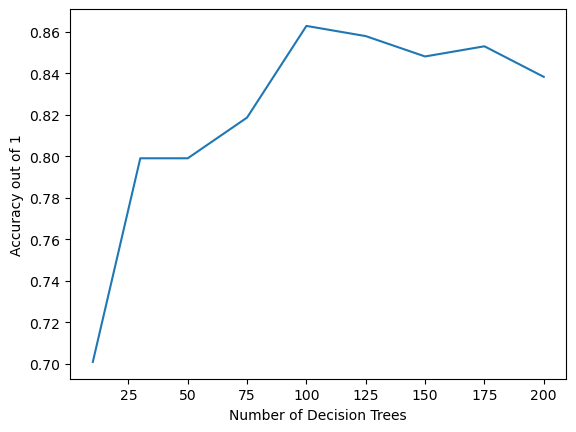

In [13]:
import matplotlib.pyplot as plt

def get_accuracy(no_decision_trees):
    ''' Builds a classifier with the given number of decision trees
        Returns accuracy value
    '''
    # random forest classification
    clf = RandomForestClassifier(n_estimators = no_decision_trees)
    clf.fit(X_train, Y_train)
    accuracy = accuracy_score(clf.predict(X_test), Y_test)
    return accuracy

# build the accuracy values for the given # of decision trees
accuracies = []
no_decisions = [10,30,50,75,100,125,150,175,200]
for number in no_decisions:
    accuracy = get_accuracy(number)
    accuracies.append(accuracy)
    
# plots accuracies 
plt.plot(no_decisions, accuracies)
plt.xlabel("Number of Decision Trees")
plt.ylabel("Accuracy out of 1")
plt.show()

It looks like the accuracy does generally tend to go up with the number of decision trees, but since there's randomness involved it's not necessarily always going to be better to have more decision trees. As we can see running the previous cell a few times, sometimes the graph does up and also down. 

3. If we had picked the amount of decision trees by taking the value with the best test accuracy from the last plot, we would have *overfit* our hyperparameters to the test data. Can you see why it is a mistake to tune hyperparameters of your model by using the test data?

Finding the optimal parameters for the given training data means that the model will be excellent for this particular data set, not necessarily the global dataset we want it to be useful for. So, this is bad. 

4. Reshuffle and resplit the data so that it is divided in 3 parts: training (80%), validation (10%) and test (10%). Repeatedly train a model of your choosing (e.g random forest) on the training data, and evaluate it’s performance on the validation set, while tuning the hyperparameters so that the accuracy on the validation set increases. Then, finally evaluate the performance of your model on the test data. What can you say in terms of the generalization of your model?

In [14]:
from sklearn.utils import shuffle

# shuffle the data
X,Y = shuffle(img_data,targets)

# split the data
training = int(X.shape[0] * 0.8)
testing = int(X.shape[0] * 0.1)

X_train = X[:training,:]
Y_train = Y[:training]

X_val = X[training:training+testing,:]
Y_val = Y[training:training+testing]

X_test  = X[training+testing:,:]
Y_test = Y[training+testing:]

# check shape
print(X_train.shape, len(Y_train))
print(X_val.shape, len(Y_val))
print(X_test.shape, len(Y_test))

(816, 1024) 816
(102, 1024) 102
(102, 1024) 102


In [15]:
# train a model of your choosing (e.g random forest) on the training data, 
# evaluate performance on validation set, while tuning the hyperparameters 
# so that the accuracy on the validation set increases

# vary the no_decision_trees
no_decision_trees = np.arange(100, 1000, 100)
val_accs = np.zeros(len(no_decision_trees))
classifiers = []

def train_model():
    # random forest classification
    for i, no in enumerate(no_decision_trees):    
        clf = RandomForestClassifier()
        clf.fit(X_train, Y_train)
        accuracy = accuracy_score(clf.predict(X_val), Y_val)
        val_accs[i] = accuracy
        classifiers.append(clf)

# Get the classifier with the highest accuracy
train_model()
print('Accuracies: ',val_accs)
print("\nNumber of decision trees resulting in the highest accuracy: ", no_decision_trees[np.argmax(val_accs)])

# get accuracy on test set
best_classifier = classifiers[np.argmax(val_accs)]
final_test_accuracy = accuracy_score(best_classifier.predict(X_test), Y_test)
print("final accuracy on test set: ", final_test_accuracy)

Accuracies:  [0.84313725 0.84313725 0.82352941 0.84313725 0.84313725 0.85294118
 0.87254902 0.8627451  0.82352941]

Number of decision trees resulting in the highest accuracy:  700
final accuracy on test set:  0.8333333333333334


5. This process of picking a suitable model, evaluating its performance and tuning the hyperparameters is very time consuming. A new idea in machine learning is the concept of automating this by using an optimization algorithm to find the best model in the space of models and their hyperparameters. Have a look at [TPOT](https://github.com/EpistasisLab/tpot), an automated ML solution that finds a good model and a good set of hyperparameters automatically. Try it on this data, it should outperform simple models like the ones we tried easily. Note that running the algorithm might take a while, depending on the strength of your computer. 

*Note*: In case it is running for too long, try checking if the parameters you are using when calling TPOT are reasonable, i.e. try reducing number of ‘generations’ or ‘population_size’. TPOT uses cross-validation internally, so we don’t need our own validation set.

In [22]:
from tpot import TPOTClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

# split the data: no validation needed since TPOT uses cross-validation internally
X_train, X_test, Y_train, Y_test = train_test_split(img_data, targets,
                                                    train_size=0.8, test_size=0.2, random_state=42)

# run TPOT
tpot = TPOTClassifier(generations=3, population_size=3, verbosity=2, max_eval_time_mins=1)
tpot.fit(X_train, Y_train)
Y_test = np.array(Y_test)
print('Score: ',tpot.score(X_test, Y_test))

Optimization Progress:   0%|          | 0/12 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8198638336076612

Generation 2 - Current best internal CV score: 0.8198638336076612

Generation 3 - Current best internal CV score: 0.8198638336076612

Best pipeline: SGDClassifier(input_matrix, alpha=0.01, eta0=0.01, fit_intercept=True, l1_ratio=0.5, learning_rate=constant, loss=log, penalty=elasticnet, power_t=100.0)
Score:  0.0


/Users/citlalitrigos/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:765: FutureWarning: sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.
  warnings.warn(
/Users/citlalitrigos/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:217: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


**Remember to submit your code on Moodle. You can return this Jupyter notebook (.ipynb) or .py, .R, etc depending on your programming preferences.**